In [1]:
import os
import torch

os.environ["TORCH"] = torch.__version__
print(torch.__version__)

d:\anaconda3\envs\kgcn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.1


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
!nvidia-smi

Wed Nov 16 21:34:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.29       Driver Version: 497.29       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8     1W /  N/A |    134MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# import required modules
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import copy
import argparse
from sklearn.metrics import roc_auc_score, f1_score

import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
from torch_geometric.utils import structured_negative_sampling, subgraph, k_hop_subgraph

In [6]:
data_path = "./data/"
# data_path = '/content/drive/MyDrive/AI_Naver_PTIT/KGCN/torch/data/'


class DataLoader:
    """
    Data Loader class which makes dataset for training / knowledge graph dictionary
    """

    def __init__(self, data):
        self.cfg = {
            "movie": {
                "item2id_path": data_path + "movie/item_index2entity_id.txt",
                "kg_path": data_path + "movie/kg.txt",
                "rating_path": data_path + "movie/ratings.csv",
                "rating_sep": ",",
                "threshold": 4.0,
            },
            "music": {
                "item2id_path": data_path + "music/item_index2entity_id.txt",
                "kg_path": data_path + "music/kg.txt",
                "rating_path": data_path + "music/user_artists.dat",
                "rating_sep": "\t",
                "threshold": 0.0,
            },
            'kkbox': {
                'item2id_path': data_path + "KKBOX_data/item_index2entity_id.txt",
                'kg_path': data_path + "KKBOX_data/kg.txt",
                'rating_path': data_path + "KKBOX_data/user_item.dat",
                'rating_sep': '\t',
                'threshold': 0.0
            },
            'ml100k': {
                'item2id_path': data_path + "ML100K/item_index2entity_id.txt",
                'kg_path': data_path + "ML100K/kg.txt",
                'rating_path': data_path + "ML100K/user_item.dat",
                'rating_sep': '\t',
                'threshold': 0.0
            },
            'bookcrossing': {
                'item2id_path': data_path + 'BookCrossing/item_index2entity_id.txt',
                'kg_path': data_path + 'BookCrossing/kg.txt',
                'rating_path': data_path + 'BookCrossing/user_item.dat',
                'rating_sep': '\t',
                'threshold': 0.0
            },
            'ml1m': {
                'item2id_path': data_path + 'ML1M/item_index2entity_id.txt',
                'kg_path': data_path + 'ML1M/kg.txt',
                'rating_path': data_path + 'ML1M/user_item.dat',
                'rating_sep': '\t',
                'threshold': 4.0
            }
        }
        self.data = data

        df_item2id = pd.read_csv(
            self.cfg[data]["item2id_path"], sep="\t", header=None, names=["item", "id"]
        )
        df_kg = pd.read_csv(
            self.cfg[data]["kg_path"],
            sep="\t",
            header=None,
            names=["head", "relation", "tail"],
        )
        df_rating = pd.read_csv(
            self.cfg[data]["rating_path"],
            sep=self.cfg[data]["rating_sep"],
            names=["userID", "itemID", "rating"],
            skiprows=1,
        )

        # df_rating['itemID'] and df_item2id['item'] both represents old entity ID
        df_rating = df_rating[df_rating["itemID"].isin(df_item2id["item"])]
        df_rating.reset_index(inplace=True, drop=True)

        self.df_item2id = df_item2id
        self.df_kg = df_kg
        self.df_rating = df_rating

        self.user_encoder = LabelEncoder()
        self.entity_encoder = LabelEncoder()
        self.relation_encoder = LabelEncoder()

        self._encoding()

    def _encoding(self):
        """
        Fit each label encoder and encode knowledge graph
        """
        self.user_encoder.fit(self.df_rating["userID"])
        # df_item2id['id'] and df_kg[['head', 'tail']] represents new entity ID
        self.entity_encoder.fit(
            pd.concat([self.df_item2id["id"], self.df_kg["head"], self.df_kg["tail"]])
        )
        self.relation_encoder.fit(self.df_kg["relation"])

        # encode df_kg
        self.df_kg["head"] = self.entity_encoder.transform(self.df_kg["head"])
        self.df_kg["tail"] = self.entity_encoder.transform(self.df_kg["tail"])
        self.df_kg["relation"] = self.relation_encoder.transform(self.df_kg["relation"])

    def _build_dataset(self):
        """
        Build dataset for training (rating data)
        It contains negative sampling process
        """
        print("Build dataset dataframe ...", end=" ")
        # df_rating update
        df_dataset = pd.DataFrame()
        df_dataset["userID"] = self.user_encoder.transform(self.df_rating["userID"])

        # update to new id
        item2id_dict = dict(zip(self.df_item2id["item"], self.df_item2id["id"]))
        self.df_rating["itemID"] = self.df_rating["itemID"].apply(
            lambda x: item2id_dict[x]
        )
        df_dataset["itemID"] = self.entity_encoder.transform(self.df_rating["itemID"])
        df_dataset["label"] = self.df_rating["rating"].apply(
            lambda x: 0 if x < self.cfg[self.data]["threshold"] else 1
        )

        # negative sampling
        df_dataset = df_dataset[df_dataset["label"] == 1]
        # df_dataset requires columns to have new entity ID
        full_item_set = set(range(len(self.entity_encoder.classes_)))
        user_list = []
        item_list = []
        label_list = []
        for user, group in df_dataset.groupby(["userID"]):
            item_set = set(group["itemID"])
            negative_set = full_item_set - item_set
            negative_sampled = random.sample(negative_set, len(item_set))
            user_list.extend([user] * len(negative_sampled))
            item_list.extend(negative_sampled)
            label_list.extend([0] * len(negative_sampled))
        negative = pd.DataFrame(
            {"userID": user_list, "itemID": item_list, "label": label_list}
        )
        df_dataset = pd.concat([df_dataset, negative])

        df_dataset = df_dataset.sample(frac=1, replace=False, random_state=999)
        df_dataset.reset_index(inplace=True, drop=True)
        print("Done")
        return df_dataset

    def _construct_kg(self):
        """
        Construct knowledge graph
        Knowledge graph is dictionary form
        'head': [(relation, tail), ...]
        """
        print("Construct knowledge graph ...", end=" ")
        kg = dict()
        for i in range(len(self.df_kg)):
            head = self.df_kg.iloc[i]["head"]
            relation = self.df_kg.iloc[i]["relation"]
            tail = self.df_kg.iloc[i]["tail"]
            if head in kg:
                kg[head].append((relation, tail))
            else:
                kg[head] = [(relation, tail)]
            if tail in kg:
                kg[tail].append((relation, head))
            else:
                kg[tail] = [(relation, head)]
        print("Done")
        return kg

    def load_dataset(self):
        return self._build_dataset()

    def load_kg(self):
        return self._construct_kg()

    def get_encoders(self):
        return (self.user_encoder, self.entity_encoder, self.relation_encoder)

    def get_num(self):
        return (
            len(self.user_encoder.classes_),
            len(self.entity_encoder.classes_),
            len(self.relation_encoder.classes_),
        )

In [6]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--dataset', type=str, default='music', help='which dataset to use')
# parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
# parser.add_argument('--n_epochs', type=int, default=25, help='the number of epochs')
# parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
# parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
# parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
# parser.add_argument('--batch_size', type=int, default=32, help='batch size')
# parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
# parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
# parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

# args = parser.parse_args([])

In [7]:
# parser = argparse.ArgumentParser()

# parser.add_argument("--dataset", type=str, default="movie", help="which dataset to use")
# parser.add_argument(
#     "--aggregator", type=str, default="neighbor", help="which aggregator to use"
# )
# parser.add_argument("--n_epochs", type=int, default=2, help="the number of epochs")
# parser.add_argument(
#     "--neighbor_sample_size",
#     type=int,
#     default=4,
#     help="the number of neighbors to be sampled",
# )
# parser.add_argument(
#     "--dim", type=int, default=32, help="dimension of user and entity embeddings"
# )
# parser.add_argument(
#     "--n_iter",
#     type=int,
#     default=2,
#     help="number of iterations when computing entity representation",
# )
# parser.add_argument("--batch_size", type=int, default=65536, help="batch size")
# parser.add_argument(
#     "--l2_weight", type=float, default=1e-7, help="weight of l2 regularization"
# )
# parser.add_argument("--lr", type=float, default=2e-2, help="learning rate")
# parser.add_argument("--ratio", type=float, default=0.6, help="size of training dataset")

# args = parser.parse_args([])

In [14]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--dataset', type=str, default='kkbox', help='which dataset to use')
# parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
# parser.add_argument('--n_epochs', type=int, default=100, help='the number of epochs')
# parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
# parser.add_argument('--dim', type=int, default=32, help='dimension of user and entity embeddings')
# parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
# parser.add_argument('--batch_size', type=int, default=32768, help='batch size')
# parser.add_argument('--l2_weight', type=float, default=1e-7, help='weight of l2 regularization')
# parser.add_argument('--lr', type=float, default=2e-2, help='learning rate')
# parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

# args = parser.parse_args([])

In [20]:
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default='ml100k', help='which dataset to use')
parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
parser.add_argument('--n_epochs', type=int, default=100, help='the number of epochs')
parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

args = parser.parse_args([])

In [21]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--dataset', type=str, default='bookcrossing', help='which dataset to use')
# parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
# parser.add_argument('--n_epochs', type=int, default=100, help='the number of epochs')
# parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
# parser.add_argument('--dim', type=int, default=32, help='dimension of user and entity embeddings')
# parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
# parser.add_argument('--batch_size', type=int, default=128, help='batch size')
# parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
# parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
# parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

# args = parser.parse_args([])

In [22]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--dataset', type=str, default='ml1m', help='which dataset to use')
# parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
# parser.add_argument('--n_epochs', type=int, default=100, help='the number of epochs')
# parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
# parser.add_argument('--dim', type=int, default=32, help='dimension of user and entity embeddings')
# parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
# parser.add_argument('--batch_size', type=int, default=2048, help='batch size')
# parser.add_argument('--l2_weight', type=float, default=1e-7, help='weight of l2 regularization')
# parser.add_argument('--lr', type=float, default=2e-2, help='learning rate')
# parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

# args = parser.parse_args([])

In [23]:
# build dataset and knowledge graph
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()
df_dataset

Construct knowledge graph ... Done
Build dataset dataframe ... Done


,userID,itemID,label
0,124,3321,0
1,681,4464,0
2,346,5188,0
3,404,662,1
4,270,646,1
...,...,...,...
199943,192,1,1
199944,384,6021,0
199945,337,1995,0
199946,534,204,1


In [24]:
# Dataset class
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]["userID"])
        item_id = np.array(self.df.iloc[idx]["itemID"])
        label = np.array(self.df.iloc[idx]["label"], dtype=np.float32)
        return user_id, item_id, label

In [25]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(
    df_dataset,
    df_dataset["label"],
    test_size=1 - args.ratio,
    shuffle=False,
    random_state=999,
)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.5, shuffle=False, random_state=999
)
train_dataset = KGCNDataset(x_train)
val_dataset = KGCNDataset(x_val)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_dataset.__len__())

## model v1: loop in batch + 1-hop

In [33]:
class KGCN_geometric_v1(MessagePassing):
    def __init__(self, num_user, num_ent, num_rel, kg, args, device):
        super(KGCN_geometric_v1, self).__init__(aggr="add")
        self.num_user = num_user
        self.num_ent = num_ent
        self.num_rel = num_rel
        self.n_iter = args.n_iter
        self.batch_size = args.batch_size
        self.dim = args.dim
        self.n_neighbor = args.neighbor_sample_size
        self.kg = kg
        self.device = device
        self.aggregator = args.aggregator

        self._gen_adj()

        self.usr = torch.nn.Embedding(num_user, args.dim)
        self.ent = torch.nn.Embedding(num_ent, args.dim)
        self.rel = torch.nn.Embedding(num_rel, args.dim)

        if self.aggregator == "concat":
            self.weights_update = torch.nn.Linear(2 * args.dim, args.dim, bias=True)
        else:
            self.weights_update = torch.nn.Linear(args.dim, args.dim, bias=True)

    def _gen_adj(self):
        """
        Generate adjacency matrix for entities and relations
        Only cares about fixed number of samples
        """
        self.adj_ent = torch.empty(self.num_ent, self.n_neighbor, dtype=torch.long)
        self.adj_rel = torch.empty(self.num_ent, self.n_neighbor, dtype=torch.long)

        indices = [[], []]
        values = []

        test_indices = []

        for e in self.kg:
            if len(self.kg[e]) >= self.n_neighbor:
                neighbors = random.sample(self.kg[e], self.n_neighbor)
                neighbors_to_sparse_coo_tensor = random.sample(
                    self.kg[e], self.n_neighbor
                )
            else:
                neighbors = random.choices(self.kg[e], k=self.n_neighbor)
                neighbors_to_sparse_coo_tensor = self.kg[e]

            self.adj_ent[e] = torch.LongTensor([ent for _, ent in neighbors])
            self.adj_rel[e] = torch.LongTensor([rel for rel, _ in neighbors])

            for rel, ent in neighbors_to_sparse_coo_tensor:
                indices[0].append(ent)
                indices[1].append(e)
                values.append(rel)

        self.edge_index = torch.tensor(indices)
        self.edge_attr = torch.tensor(values)

    def forward(self, user_indices, item_indices, device):

        list_batch_score = torch.tensor([]).to(device)

        for i, u in zip(
            item_indices, user_indices
        ):  # edge_index_subset[1] ~ target node
            i_ = i.item()
            u_ = u.item()

            # get subset of target node i from
            (
                subset_i,
                edge_index_subset_i,
                mapping_i,
                edge_mask_subset_i,
            ) = k_hop_subgraph(i_, 1, self.edge_index)
            edge_index_subset_i, edge_attr_subset_i = subgraph(
                subset_i, self.edge_index, self.edge_attr
            )

            # reshape test [-1, 2]
            edge_index_subset_i = edge_index_subset_i.t().reshape(-1, 2)

            # get only row that have i in second column and get mask
            edge_mask_subset_i = edge_index_subset_i[:, 1] == i_
            edge_attr_subset_i = edge_attr_subset_i[edge_mask_subset_i]
            edge_index_subset_i = edge_index_subset_i[edge_mask_subset_i]

            # reshape test [2, -1]
            edge_index_subset_i = edge_index_subset_i.t().reshape(2, -1)
            edge_index_subset_i = edge_index_subset_i.to(device)
            edge_attr_subset_i = edge_attr_subset_i.to(device)

            # get user emb by with index u
            user_embedding = self.usr(u)

            relation_vectors = self.rel(edge_attr_subset_i)

            # get item emb is item_emb
            user_relation_score = (user_embedding * relation_vectors).sum(dim=-1)

            user_relation_score_normalized = F.softmax(user_relation_score, dim=-1)

            item_emb = self.propagate(
                edge_index_subset_i,
                x=self.ent.weight,
                user_relation_score_normalized=user_relation_score_normalized,
                id_item_src=i_,
            )

            score = (item_emb * user_embedding).sum(dim=-1)

            list_batch_score = torch.cat((list_batch_score, score.unsqueeze(-1)))

        return torch.sigmoid(list_batch_score)

    def message(self, x_j, user_relation_score_normalized) -> Tensor:
        user_relation_score_normalized = user_relation_score_normalized.unsqueeze(
            dim=-1
        )
        neighbor_vectors = x_j
        neighbors_aggregated = user_relation_score_normalized * neighbor_vectors
        return neighbors_aggregated

    def update(self, aggr_out, x_i, id_item_src):
        self_vectors = x_i[0]
        neighbors_agg = aggr_out[id_item_src]

        if self.aggregator == "sum":
            output = self_vectors + neighbors_agg
        elif self.aggregator == "concat":
            output = torch.cat((self_vectors, neighbors_agg))
        else:
            output = neighbors_agg
        output = self.weights_update(output)
        return torch.tanh(output)

## model v2: parallel in batch + 1-hop

In [ ]:
import sys
import torch
import torch.nn.functional as F
import random
import numpy as np
import copy


class KGCN_geometric_v2(MessagePassing):
    def __init__(self, num_user, num_ent, num_rel, kg, args, device):
        super(KGCN_geometric_v2, self).__init__(aggr="add")
        self.num_user = num_user
        self.num_ent = num_ent
        self.num_rel = num_rel
        self.n_iter = args.n_iter
        self.batch_size = args.batch_size
        self.dim = args.dim
        self.n_neighbor = args.neighbor_sample_size
        self.kg = kg
        self.device = device
        self.aggregator = args.aggregator

        self._gen_adj()

        self.usr = torch.nn.Embedding(num_user, args.dim)
        self.ent = torch.nn.Embedding(num_ent, args.dim)
        self.rel = torch.nn.Embedding(num_rel, args.dim)

        if self.aggregator == "concat":
            self.weights_update = torch.nn.Linear(2 * args.dim, args.dim, bias=True)
        else:
            self.weights_update = torch.nn.Linear(args.dim, args.dim, bias=True)

    def _gen_adj(self):
        """
        Generate adjacency matrix for entities and relations
        Only cares about fixed number of samples
        """

        indices = [[], []]
        values = []

        test_indices = []

        self.list_id_neighbor = np.full((self.num_ent, self.n_neighbor), -1)
        self.list_id_edge = np.full((self.num_ent, self.n_neighbor), -1)

        for e in self.kg:
            if len(self.kg[e]) >= self.n_neighbor:
                neighbors_to_sparse_coo_tensor = random.sample(
                    self.kg[e], self.n_neighbor
                )
            else:
                neighbors_to_sparse_coo_tensor = random.choices(
                    self.kg[e], k=self.n_neighbor
                )
            self.list_id_neighbor[e] = [
                ent for _, ent in neighbors_to_sparse_coo_tensor
            ]
            self.list_id_edge[e] = [rel for rel, _ in neighbors_to_sparse_coo_tensor]
            for rel, ent in neighbors_to_sparse_coo_tensor:
                indices[0].append(ent)
                indices[1].append(e)
                values.append(rel)

        self.edge_index = torch.tensor(indices)
        self.edge_attr = torch.tensor(values)

    def forward(self, user_indices, item_indices, device):

        list_node_id_1_hop_item = torch.tensor(
            np.array(
                [
                    self.list_id_neighbor[item_indices].flatten(),
                    np.array(np.repeat(item_indices, self.n_neighbor)),
                ],
                dtype=np.int64,
            )
        ).to(device)
        list_edge_attr_id_1_hop_item = torch.tensor(self.list_id_edge[item_indices]).to(
            device
        )

        user_embeddings = self.usr(user_indices)

        relation_vectors = self.rel(list_edge_attr_id_1_hop_item)

        user_relation_scores = (
            user_embeddings.view((-1, 1, self.dim)) * relation_vectors
        ).sum(dim=-1)

        user_relation_scores_normalized = F.softmax(user_relation_scores, dim=-1)

        item_embs = self.propagate(
            list_node_id_1_hop_item,
            x=self.ent.weight,
            user_relation_scores_normalized=user_relation_scores_normalized,
            item_indices=item_indices,
        )

        scores = (item_embs * user_embeddings).sum(dim=-1)

        return torch.sigmoid(scores)

    def message(self, x_j, user_relation_scores_normalized, item_indices) -> Tensor:
        user_relation_scores_normalized = torch.flatten(
            user_relation_scores_normalized
        ).view(-1, 1)
        neighbor_vectors = x_j
        neighbors_aggregated = user_relation_scores_normalized * neighbor_vectors
        return neighbors_aggregated

    def update(self, aggr_out, x_i, item_indices):
        self_vectors = x_i[:: self.n_neighbor]
        neighbors_agg = aggr_out[item_indices]
        if self.aggregator == "sum":
            output = self_vectors + neighbors_agg
        elif self.aggregator == "concat":
            output = torch.cat((self_vectors, neighbors_agg))
        else:
            output = neighbors_agg
        output = self.weights_update(output)
        return torch.tanh(output)

## model v3: parallel in batch + k-hop

In [26]:
import sys
import torch
import torch.nn.functional as F
import random
import numpy as np
import copy


class KGCN_geometric_v3(MessagePassing):
    def __init__(self, num_user, num_ent, num_rel, kg, args, device):
        super(KGCN_geometric_v3, self).__init__(aggr="add")
        self.num_user = num_user
        self.num_ent = num_ent
        self.num_rel = num_rel
        self.n_iter = args.n_iter
        self.batch_size = args.batch_size
        self.dim = args.dim
        self.n_neighbor = args.neighbor_sample_size
        self.kg = kg
        self.device = device
        self.aggregator = args.aggregator

        self._gen_adj()

        self.usr = torch.nn.Embedding(num_user, args.dim)
        self.ent = torch.nn.Embedding(num_ent, args.dim)
        self.rel = torch.nn.Embedding(num_rel, args.dim)

        if self.aggregator == "concat":
            self.weights_update = torch.nn.Linear(2 * args.dim, args.dim, bias=True)
        else:
            self.weights_update = torch.nn.Linear(args.dim, args.dim, bias=True)

    def _gen_adj(self):
        """
        Generate adjacency matrix for entities and relations
        Only cares about fixed number of samples
        """

        indices = [[], []]
        values = []

        test_indices = []

        self.list_id_neighbor = np.full((self.num_ent, self.n_neighbor), -1)
        self.list_id_edge = np.full((self.num_ent, self.n_neighbor), -1)

        for e in self.kg:
            if len(self.kg[e]) >= self.n_neighbor:
                neighbors_to_sparse_coo_tensor = random.sample(
                    self.kg[e], self.n_neighbor
                )
            else:
                neighbors_to_sparse_coo_tensor = random.choices(
                    self.kg[e], k=self.n_neighbor
                )
            self.list_id_neighbor[e] = [
                ent for _, ent in neighbors_to_sparse_coo_tensor
            ]
            self.list_id_edge[e] = [rel for rel, _ in neighbors_to_sparse_coo_tensor]
            for rel, ent in neighbors_to_sparse_coo_tensor:
                indices[0].append(ent)
                indices[1].append(e)
                values.append(rel)

        self.edge_index = torch.tensor(indices)
        self.edge_attr = torch.tensor(values)

    def forward(self, user_indices_origin, item_indices_origin, device):

        list_k_hop_user = [user_indices_origin]
        list_k_hop_item = [item_indices_origin]

        list_ent_weight = [self.ent.weight]

        for i in range(self.n_iter - 1):

            unique_id_neighbor, unique_indices = np.unique(
                self.list_id_neighbor[list_k_hop_item[0].cpu()], return_index=True
            )
            list_k_hop_user.insert(
                0,
                np.repeat(list_k_hop_user[0].cpu(), self.n_neighbor)[unique_indices]
                .clone()
                .detach(),
            )
            list_k_hop_item.insert(0, torch.tensor(unique_id_neighbor))

        current_hop = 0

        for user_indices, item_indices in zip(list_k_hop_user, list_k_hop_item):
            user_indices = user_indices.to(device)
            # user_indices = torch.tensor(user_indices.clone().detach()).to(device)
            # user_indices = user_indices.clone().detach()

            if current_hop == self.n_iter - 1:
                act = torch.tanh
            else:
                act = torch.sigmoid
            current_hop += 1
            list_node_id_1_hop_item = torch.tensor(
                np.array(
                    [
                        self.list_id_neighbor[item_indices.cpu()].flatten(),
                        np.array(np.repeat(item_indices.cpu(), self.n_neighbor)),
                    ],
                    dtype=np.int64,
                )
            ).to(device)
            list_edge_attr_id_1_hop_item = torch.tensor(
                self.list_id_edge[item_indices.cpu()]
            ).to(device)

            user_embeddings = self.usr(user_indices)
            relation_vectors = self.rel(list_edge_attr_id_1_hop_item)

            user_relation_scores = (
                user_embeddings.view((-1, 1, self.dim)) * relation_vectors
            ).sum(dim=-1)
            user_relation_scores_normalized = F.softmax(user_relation_scores, dim=-1)

            item_embs = self.propagate(
                list_node_id_1_hop_item,
                x=list_ent_weight[-1],
                user_relation_scores_normalized=user_relation_scores_normalized,
                item_indices=item_indices,
                act=act,
            )
            tmp = list_ent_weight[-1].clone()
            tmp[item_indices] = item_embs
            list_ent_weight.append(tmp)

        scores = (item_embs * user_embeddings).sum(dim=-1)

        return torch.sigmoid(scores)

    def message(
        self, x_j, user_relation_scores_normalized, item_indices, act
    ) -> Tensor:
        user_relation_scores_normalized = torch.flatten(
            user_relation_scores_normalized
        ).view(-1, 1)
        neighbor_vectors = x_j
        neighbors_aggregated = user_relation_scores_normalized * neighbor_vectors
        return neighbors_aggregated

    def update(self, aggr_out, x_i, item_indices, act):
        self_vectors = x_i[:: self.n_neighbor]
        neighbors_agg = aggr_out[item_indices]
        if self.aggregator == "sum":
            output = self_vectors + neighbors_agg
        elif self.aggregator == "concat":
            output = torch.cat((self_vectors, neighbors_agg), 1)
        else:
            output = neighbors_agg
        output = self.weights_update(output)
        return act(output)

## train

In [34]:
# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = KGCN_geometric_v3(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)
print("device: ", device)

device:  cuda


In [35]:
name_version = "KGCN_geometric"
patience = 5

In [36]:
from pytorchtools import EarlyStopping
# add early stopping
early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'./checkpoint/{name_version}_{args.dataset}.pt', delta=0.005)

# train
loss_list = []
val_loss_list = []
auc_score_list = []
f1_score_list = []

import time

start_train = time.time()
print("start_train:", start_train)


for epoch in range(args.n_epochs):
    running_loss = 0.0

    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = (
            user_ids.to(device),
            item_ids.to(device),
            labels.to(device),
        )
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids, device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # print train loss per every epoch
    print("[Epoch {}]".format(epoch + 1))
    print("train_loss: ".format(epoch + 1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))

    # evaluate per every epoch
    with torch.no_grad():
        val_loss = 0
        total_roc = 0
        total_f1 = 0
        for user_ids, item_ids, labels in val_loader:
            user_ids, item_ids, labels = (
                user_ids.to(device),
                item_ids.to(device),
                labels.to(device),
            )
            outputs = net(user_ids, item_ids, device)
            val_loss += criterion(outputs, labels).item()
            outputs = outputs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            total_roc += roc_auc_score(labels, outputs)
            outputs = np.where(outputs >= 0.5, 1, 0)
            total_f1 += f1_score(labels, outputs)

        print("val_loss: ".format(epoch + 1), val_loss / len(val_loader))
        print("val_auc: ".format(epoch + 1), total_roc / len(val_loader))
        print("val_f1: ".format(epoch + 1), total_f1 / len(val_loader))
        print("--------------------------------")
        val_loss_list.append(val_loss / len(val_loader))
        auc_score_list.append(total_roc / len(val_loader))
        f1_score_list.append(total_f1 / len(val_loader))

    # early stopping
    early_stopping(val_loss / len(val_loader), net)
    if early_stopping.early_stop:
        print("Early stopping")
        break

end_train = time.time()
print("end_train:", end_train)
print("end_train - start_train:", end_train - start_train)

start_train: 1668615895.3795166
[Epoch 1]
train_loss:  0.7530119030968162
val_loss:  0.6268425005197525
val_auc:  0.7318534294871865
val_f1:  0.689697805879841
--------------------------------
Validation loss decreased (inf --> 0.626843).  Saving model ...
[Epoch 2]
train_loss:  0.5380868607320668
val_loss:  0.4278646178603172
val_auc:  0.8871415692640742
val_f1:  0.8273852800493281
--------------------------------
Validation loss decreased (0.626843 --> 0.427865).  Saving model ...
[Epoch 3]
train_loss:  0.3162805689178322
val_loss:  0.25619533848911524
val_auc:  0.9569658036408044
val_f1:  0.9063461733368382
--------------------------------
Validation loss decreased (0.427865 --> 0.256195).  Saving model ...
[Epoch 4]
train_loss:  0.23930880247207126
val_loss:  0.23701155314296485
val_auc:  0.9595681464368967
val_f1:  0.9106198421638545
--------------------------------
Validation loss decreased (0.256195 --> 0.237012).  Saving model ...
[Epoch 5]
train_loss:  0.2295905004369001
val_l

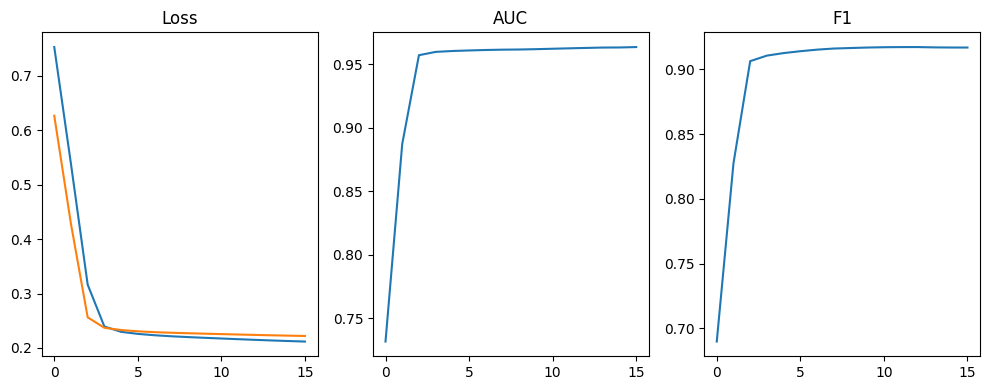

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.plot(loss_list)
ax1.plot(val_loss_list)
ax1.set_title("Loss")
ax2.plot(auc_score_list)
ax2.set_title("AUC")
ax3.plot(f1_score_list)
ax3.set_title("F1")

plt.tight_layout()


In [38]:
# load the last checkpoint with the best model
net = KGCN_geometric_v3(num_user, num_entity, num_relation, kg, args, device).to(device)
net.load_state_dict(torch.load(f'./checkpoint/{name_version}_{args.dataset}.pt'))

# test
with torch.no_grad():
    total_roc = 0
    total_f1 = 0
    for user_ids, item_ids, labels in test_loader:
        user_ids, item_ids, labels = (
            user_ids.to(device),
            item_ids.to(device),
            labels.to(device),
        )
        outputs = net(user_ids, item_ids, device)
        outputs = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        print("outputs:", outputs)
        print("labels:", labels)
        total_roc += roc_auc_score(labels, outputs)
        outputs = np.where(outputs >= 0.5, 1, 0)
        total_f1 += f1_score(labels, outputs)

    print("test_auc: ", total_roc / len(test_loader))
    print("test_f1: ", total_f1 / len(test_loader))

outputs: [0.9889798  0.02696869 0.9879354  ... 0.9639119  0.9843089  0.9814761 ]
labels: [1. 0. 1. ... 0. 1. 1.]
test_auc:  0.8455148253440717
test_f1:  0.8186439953859956
